
# SEXIST TWEETS CLASSIFICATION - A NLP Study
### ML for NLP class - ENSAE 2021/2022
### Prisca BAHI, Matteo CUVELIER

##Introduction
Our project consists in studying tweets and their sexist charcter. The idea will be to classify tweets in sexists and non sexists tweets.

Our data consists in more than 13k tweets classified in sexists and non sexists. You can find the the source of the data here : [link](https://data.gesis.org/sharing/#!Detail/10.7802/2251)

For that, we use the TweetTokenizer, a count-based embedding (TfIdfVectorizer) and the fasttext embeddings.

Concerning the methods we use Naive Bayes Classifier, SVM, KNN, Random Forest, fastText’s supervized classifier and LSTM. 

We then compare those models and conclude.

<a id="toc"></a>
## Table of contents
- **[I - Preliminaries](#prelim)**
  - [I.1 - Packages import](#pimport) : Import packages to process the data and perform our models.
  - [I.2 - Importing data](#dimport) : Import data to lead our study.
  - [I.3 - Data Enrichment](#denrich) : Enriching the datasets with descriptive variables of the textual data.
  - [I.4 - Data Cleaning](#dcleaning) : Cleaning the textual data to lead the study.
- **[II - Data Vizualisation](#dviz)**
  - [II.1 - Descriptive Statistics](#statsdesc) : Basic statistics over the database.
  - [II.2 - Sexism in function of length and special characters](#sexismfct) : Visualization of the impact of some variables on the distribution of sexist and non sexist tweets.
  - [II.3 - WordClouds](#wordclouds) : Visualization of most used words in sexist and non sexist tweets.
- **[III - Tokenization and embeddings](#tokembed)**
  - [III.1 - TweetTokenizer](#tweettok) : Tokenization of the tweets.
  - [III.2 - TfIdfVEctorizer : Count-based embedding](#tfidfvect) : TfIdfVEctorizer embeddings for Naive Bayes Classifier.
  - [III.3 Embeddings fasttext](#embft) : FastText embeddings (word2vec) for the database, designed for most of ML algorithms (vectors of floats of dimension 300).
- **[IV. Modelization](#model)**
  - [IV.1 - Naive Bayes Classifier](#nbclas) : Probabilist algoritghm.
  - [IV.2 - SVM](#svm) : Dimension augmentation and frontier definition.
  - [IV.3 - KNN](#knn) : Attribution of the class of the neirest neighbors (euclidian distance).
  - [IV.4 - Random Forest](#rforest) : Ensemble method with a set of decision trees.
  - [IV.5 - FastText supervized classifier](#ftsupclas) : One hidden layer neural network.
  - [IV.6 - LSTM](#lstm) : Simple deep learning method.
- **[V - Comparison and conclusion](#ccl)**
  - [V.1 - Comparison](#comp) : Comparison table and comments over the obtained results.
  - [V.2 - Conclusion](#conclu) : Conclusion on the study.


<a id="prelim"></a>
## I - Preliminaries
The aim of this first part is to load all the necessary libraries and data and to enrich our dataset.

<a id="pimport"></a>
### I.1 - Packages import
First, let's import the packages needed all along this study.

In [1]:
#Install missing libraries 
import os
os.system('pip install wget')
os.system('pip3 install pickle5')
os.system('pip install plot_keras_history')
os.system('pip install transformers')
os.system('pip install emoji')
os.system('pip install demoji')
os.system('pip install contractions')
os.system('pip install fasttext')

#Import general purpose and data manipulation libraries
import time
import zipfile
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns
color = sns.color_palette()
import pickle5 as pickle
%matplotlib inline

#Import NLP libraries
import re
import string
import nltk
from nltk.tokenize import word_tokenize , TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel, create_optimizer, BertModel, AdamW, get_linear_schedule_with_warmup
import fasttext

#Import ML libraries 
## SKLEARN
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer ,CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, multilabel_confusion_matrix, roc_auc_score, average_precision_score, recall_score, precision_score, matthews_corrcoef, accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
## TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, LSTM, Embedding, Input, Bidirectional, GlobalMaxPool1D, Dropout, GRU, Flatten
from tensorflow.keras.initializers import Constant
from plot_keras_history import plot_history
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
## Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from typing import Tuple, List
from functools import partial
## Keras
from keras.preprocessing.sequence import pad_sequences

#Import specific libraries
import emoji
import demoji
import contractions


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<a id="dimport"></a>
### I.2 - Importing data
This part will download the database from a personal hosting and load it into pandas DataFrames. Some basic descriptions about the size of the database are provided here too. We see that we have a database of over 13k tweets containing approximately 2k sexist tweets.

In [2]:
#Downloading data files
import wget
wget.download('http://nlpproject.cvlr.fr/sexism_annotations.csv')
wget.download('http://nlpproject.cvlr.fr/sexism_data.csv')
wget.download('http://nlpproject.cvlr.fr/scales.csv')
print('Data Downloaded')

#Loading data into pandas dataframes
annotations = pd.read_csv("sexism_annotations.csv", sep=",")
data = pd.read_csv("sexism_data.csv", sep=",")
scales = pd.read_csv("scales.csv", sep=",", encoding='cp1252')
print('Data Loaded')

Data Downloaded
Data Loaded


In [3]:
#Main database
print('Size :', data.shape)
data.head(3)

Size : (13631, 6)


,id,dataset,text,toxicity,sexist,of_id
0,0,other,MENTION3481 i didn't even know random was an o...,0.118180,False,-1
1,1,other,Bottom two should've gone! #mkr,0.251850,False,-1
2,2,callme,MENTION3111 MENTION3424 ladyboner deserves so ...,0.113331,False,-1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13631 entries, 0 to 13630
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13631 non-null  int64  
 1   dataset   13631 non-null  object 
 2   text      13631 non-null  object 
 3   toxicity  13631 non-null  float64
 4   sexist    13631 non-null  bool   
 5   of_id     13631 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 545.9+ KB


In [5]:
print("Check for missing values in dataset")
print(data.isnull().sum())

Check for missing values in dataset
id          0
dataset     0
text        0
toxicity    0
sexist      0
of_id       0
dtype: int64


In [6]:
#Repartition in the database
print("Total number of omments = ",len(data))
print("Total number of non-sexist comments = ",data['sexist'].value_counts()[False])
print("Total number of sexist comments = ", data['sexist'].value_counts()[True])

Total number of omments =  13631
Total number of non-sexist comments =  11822
Total number of sexist comments =  1809


In [7]:
#Annotations database (types of sexist flagging, details)
print('Size :', annotations.shape)
annotations.head(3)

Size : (28250, 4)


,phrasing,content,worker,id
0,3,2,0,1815
1,3,6,1,1815
2,3,6,2,1815


In [8]:
#Scales database (references in litterature to classify as sexist of not)
print('Size :', scales.shape)
scales.head()

Size : (29, 4)


,scale,reference,description,Unnamed: 3
0,Attitudes towards Women Scale,(Spence and Helmreich 1972),Attitudes towards the role of women in society,NaN
1,Sex Role Scale,(Rombough and Ventimiglia 1981),Attitudes towards sex roles,NaN
2,Modern Sexism Scale,(Swim et al. 1995),Old fashioned and modern sexism,NaN
3,Neosexism Scale,(Tougas et al. 1995),Egalitarian values vs. negative feelings towar...,NaN
4,Ambivalent Sexism Inventory,(Glick and Fiske 1996),Hostile & benevolent sexism,NaN


<a id="denrich"></a>
### I.3 - Database Enrichment
Here, the goal is to enrich the database with descriptive variables about the tweets that we will consider for our study.

In [9]:
#Number of capitals in the tweet
data['capitals'] = data['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

#Dummy variables for tweets only in upper case
data["uppercase_comments"] = data['text'].apply(lambda x: 1 if x.isupper() else 0)

#Number of punctuations in the tweet
data['punctuations'] = data['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

#Length of the tweet
data['length'] = data['text'].apply(len)

#Number of punctuations in the tweet
data['words'] = data["text"].apply(lambda x: len(str(x).split()))

#Number of sentences in the tweet
data['sentences'] = data["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Number of emojis in the tweet
data['emojis'] = data['text'].apply(lambda comment: sum(comment.count(s) for s in emoji.UNICODE_EMOJI))

#Number of hashtags in the tweet
data['hashtag'] = data['text'].apply(lambda comment: len(re.findall(r"#(\w+)",comment )))



<a id="dcleaning"></a>
### I.4 - Data Cleaning
The goal here is to clean the database to obtain an exploitable tweet database (no parasite words, no stopwords...).

In [10]:
#Cleaning functions
def remove_URL(text):
  """ Takes a string in input and removes the URLs in this string. """
  return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
  """ Takes a string in input and removes the HTML tags in this string. """
  html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
  return re.sub(html, "", text)

def remove_non_ascii(text):
  """ Takes a string in input and removes the non ASCII characters in this string. """
  return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_mention(text):
  """ Takes a string in input and removes the mentions (mentionning someone on twitter) in this string. """
  return re.sub(r"mention?.{4}[0-9]", "", text)

def remove_stopwords(text):
  """ Takes a string in input and removes the mentions (mentionning someone on twitter) in this string. """
  word_list = text.split(' ')
  res = " ".join([word for word in word_list if word not in stopwords.words('english')])
  return res

In [11]:
#Putting all text in lower case
data["clean_tweet"] = data["text"].apply(lambda x: x.lower())

#Removing the URLs
data["clean_tweet"] = data["clean_tweet"].apply(lambda x: remove_URL(x))

#Removing the HTML tags
data["clean_tweet"] = data["clean_tweet"].apply(lambda x: remove_html(x))

#Removing the non ASCII characters
data["clean_tweet"] = data["clean_tweet"].apply(lambda x: remove_non_ascii(x))

#Removing the twitter mentions
data["clean_tweet"] = data["clean_tweet"].apply(lambda x: remove_mention(x))

#Removing stopwords
data["clean_tweet"] = data["clean_tweet"].apply(lambda x: remove_stopwords(x))

#Reformatting the variable of interest (to be sexist) in dummy variables
data['is_sexist'] = data['sexist'].copy()
data['sexist'] = data['is_sexist'].apply(lambda x : 1 if x == True else 0)
data['not_sexist'] = data['is_sexist'].apply(lambda x : 0 if x == True else 1)

In [12]:
#After cleaning we can extract the hashtags and store them in another variable 
#Extracting function
def extract_hash_tags(text):
  """ Takes a string in input and extracts the hashtags in this string. """
  return [part[1:] for part in text.split() if part.startswith('#') ]

#Adding to the database
data["hashtag_content"] = data["clean_tweet"].apply(lambda x: extract_hash_tags(x))

In [13]:
#Resulting database
data.head(3)

,id,dataset,text,toxicity,sexist,of_id,capitals,uppercase_comments,punctuations,length,words,sentences,emojis,hashtag,clean_tweet,is_sexist,not_sexist,hashtag_content
0,0,other,MENTION3481 i didn't even know random was an o...,0.118180,0,-1,7,0,2,52,9,1,2,0,even know random option!,False,1,[]
1,1,other,Bottom two should've gone! #mkr,0.251850,0,-1,1,0,3,32,5,1,0,1,bottom two gone! #mkr,False,1,[mkr]
2,2,callme,MENTION3111 MENTION3424 ladyboner deserves so ...,0.113331,0,-1,14,0,3,103,12,1,7,2,ladyboner deserves much credit dudeboner. #b...,False,1,"[bonerdebate, reddetails]"


## II - Data Vizualisation
Now that we have a complete and clean database we can display some vizualisations on it to dig in its content.

### II.1 - Descriptive statistics

Counts of sexists and non sexists tweets :
sexist
0         11822
1          1809
dtype: int64

Graphical representation :


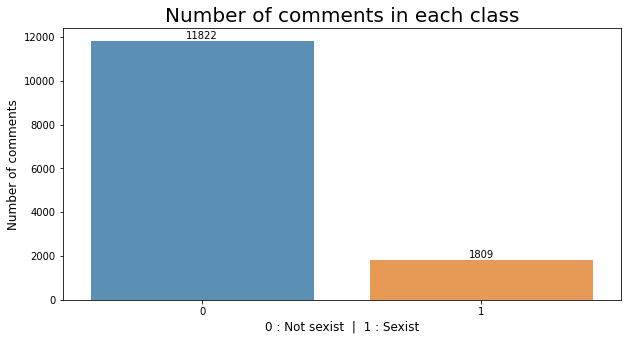

In [14]:
#Number of sexists and non sexists tweets
x = data[["sexist"]].value_counts()
print("Counts of sexists and non sexists tweets :")
print(x)
print()

#Displaying the counts on a plot
print('Graphical representation :')
plt.figure(figsize=(10,5))
ax= sns.barplot(x=[i[0] for i in list(x.index)], y=list(x.values), alpha=0.8)
plt.title("Number of comments in each class", fontsize=20)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('0 : Not sexist  |  1 : Sexist', fontsize=12)
#Adding labels with the counts
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [15]:
print(data[['sexist', 'capitals', 'uppercase_comments', 'punctuations', 'length', 'words', 'sentences', 'emojis', 'hashtag']].describe().to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &        sexist &      capitals &  uppercase\_comments &  punctuations &        length &         words &     sentences &        emojis &       hashtag \\
\midrule
count &  13631.000000 &  13631.000000 &        13631.000000 &  13631.000000 &  13631.000000 &  13631.000000 &  13631.000000 &  13631.000000 &  13631.000000 \\
mean  &      0.132712 &      7.677940 &            0.014086 &      3.922896 &     85.236153 &     14.602083 &      1.078644 &      1.852615 &      0.465556 \\
std   &      0.339276 &      7.642326 &            0.117848 &      3.057315 &     36.079736 &      6.621026 &      0.506574 &      1.749225 &      0.803403 \\
min   &      0.000000 &      0.000000 &            0.000000 &      0.000000 &      4.000000 &      1.000000 &      1.000000 &      0.000000 &      0.000000 \\
25\%   &      0.000000 &      2.000000 &            0.000000 &      2.000000 &     55.000000 &      9.000000 &      1.000000 &      0.000000 &      0.000000 \\
5

In [16]:
#We can then display some basic statistics over our database
data[['sexist', 'capitals', 'uppercase_comments', 'punctuations', 'length', 'words', 'sentences', 'emojis', 'hashtag']].describe()

,sexist,capitals,uppercase_comments,punctuations,length,words,sentences,emojis,hashtag
count,13631.000000,13631.000000,13631.000000,13631.000000,13631.000000,13631.000000,13631.000000,13631.000000,13631.000000
mean,0.132712,7.677940,0.014086,3.922896,85.236153,14.602083,1.078644,1.852615,0.465556
std,0.339276,7.642326,0.117848,3.057315,36.079736,6.621026,0.506574,1.749225,0.803403
min,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2.000000,55.000000,9.000000,1.000000,0.000000,0.000000
50%,0.000000,7.000000,0.000000,3.000000,86.000000,15.000000,1.000000,1.000000,0.000000
75%,0.000000,10.000000,0.000000,6.000000,117.000000,20.000000,1.000000,3.000000,1.000000
max,1.000000,106.000000,1.000000,30.000000,206.000000,41.000000,17.000000,12.000000,10.000000


Text(0.5, 1.0, 'Repartition of Tweets by number of capitals')

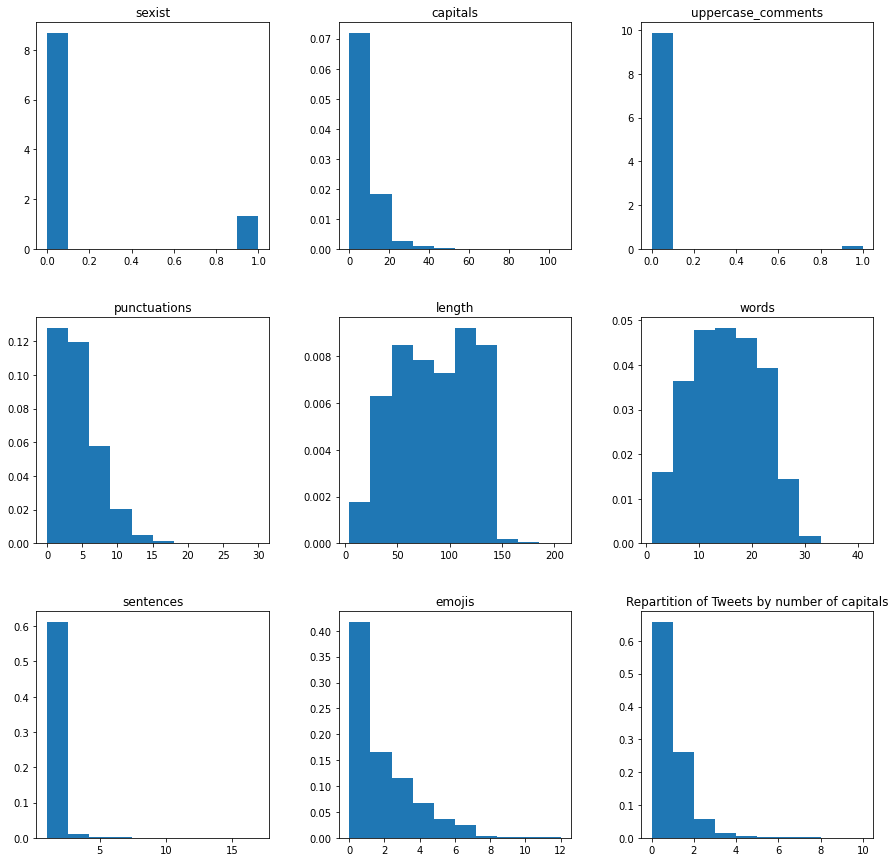

In [17]:
#To refine those statistics let's plot the distributions of these variables
data[['sexist', 'capitals', 'uppercase_comments', 'punctuations', 'length', 'words', 'sentences', 'emojis', 'hashtag']].hist(figsize=(15,15), grid=False, density=True)
plt.title('Repartition of Tweets by number of capitals')

We note that :
- The average tweet is 85 characters long, 15 words long and 1 sentence long
- A tweet averagely contains 8 capital letters, 4 punctuation signs, 2 emojis and 0,5 hashtags
- 13% of our tweets are sexist
- 1,5% of tweets are in upper case

It's interesting to add that the length distributions (words, characters and sentences) are almost uniform while for capital letters, puctuation, emojis and hashtags the majority of the distribution is close to the little values (respectively for each variable).

### II.2 Sexism in function of length and special characters
We now study the distributions of length and special characters usage regarding if the tweets are sexists or not.

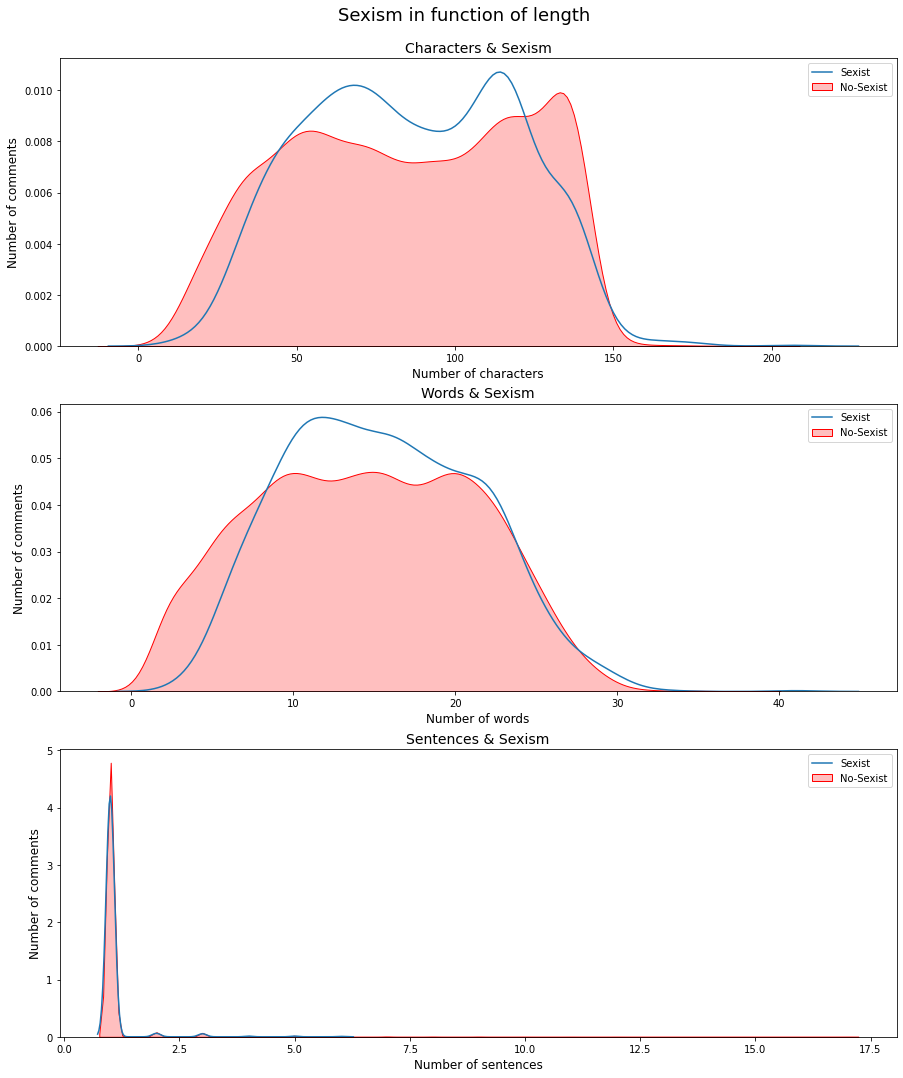

In [18]:
plt.figure(figsize=(15,18))
plt.suptitle("Sexism in function of length",y=0.92,fontsize=18)
plt.tight_layout()

# Number of characters
plt.subplot(311)
ax=sns.kdeplot(data.loc[data.sexist == 0, "length"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "length"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of characters', fontsize=12)
plt.title("Characters & Sexism", fontsize=14)

# Number of words
plt.subplot(312)
ax=sns.kdeplot(data.loc[data.sexist == 0, "words"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "words"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.title("Words & Sexism", fontsize=14)

# Number of sentences
plt.subplot(313)
ax=sns.kdeplot(data.loc[data.sexist == 0, "sentences"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "sentences"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of sentences', fontsize=12)
plt.title("Sentences & Sexism", fontsize=14)

plt.show()

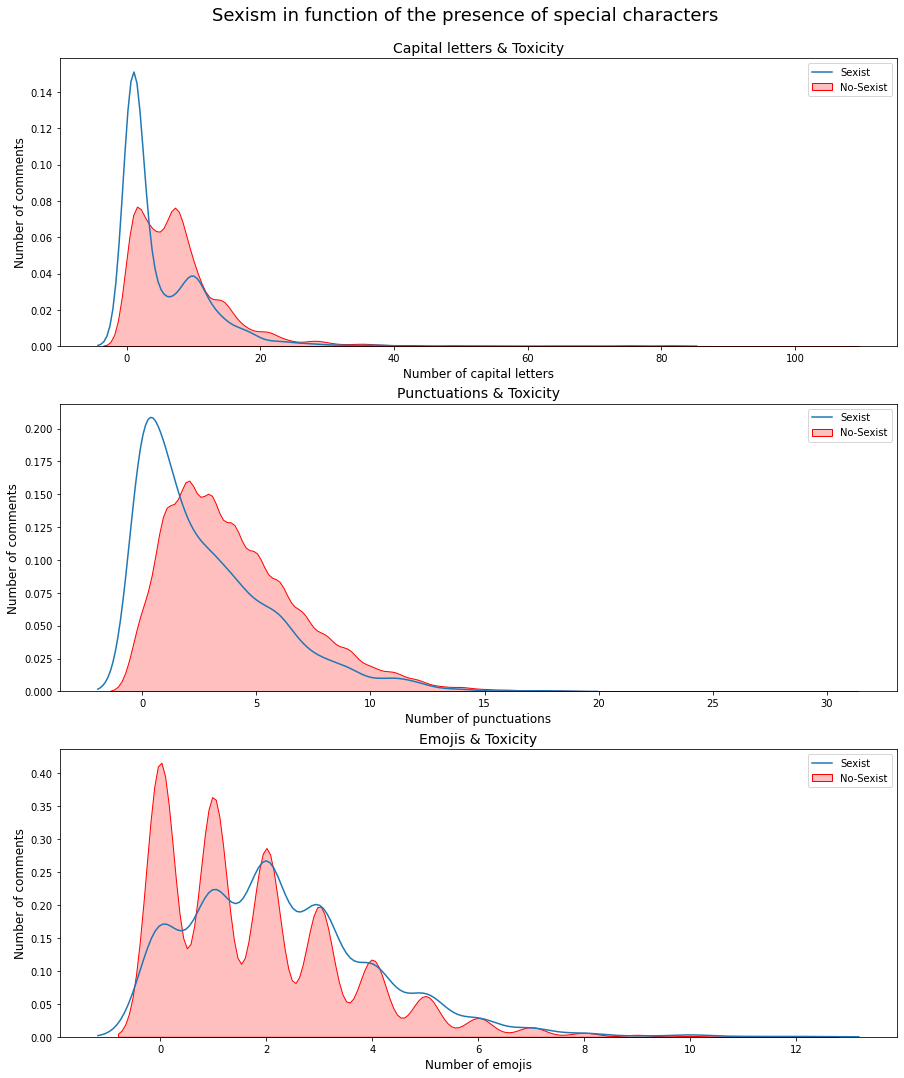

In [19]:
plt.figure(figsize=(15,18))
plt.suptitle("Sexism in function of the presence of special characters",y=0.92,fontsize=18)
plt.tight_layout()

plt.subplot(311)
ax=sns.kdeplot(data.loc[data.sexist == 0, "capitals"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "capitals"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of capital letters', fontsize=12)
plt.title("Capital letters & Toxicity", fontsize=14)

plt.subplot(312)
ax=sns.kdeplot(data.loc[data.sexist == 0, "punctuations"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "punctuations"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of punctuations', fontsize=12)
plt.title("Punctuations & Toxicity", fontsize=14)

plt.subplot(313)
ax=sns.kdeplot(data.loc[data.sexist == 0, "emojis"], label="No-Sexist", shade=True, color='r')
ax=sns.kdeplot(data.loc[data.sexist == 1, "emojis"], label="Sexist")
plt.legend()
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of emojis', fontsize=12)
plt.title("Emojis & Toxicity", fontsize=14)

plt.show()

**From those graphs we can note that the length is slightly different between sexists and non sexists tweets (they seem to be a bit longer in average). Also we see that sexists tweets use less capital letters and punctuation (and slightly more emojis).**

### II.3 - WordClouds
Another way to discriminate the sexist and non sexist tweets is to differenciate the vocabulary used. For that we represented the most used words in wordclouds for sexist (first) and non sexist (then) tweets.

(-0.5, 399.5, 199.5, -0.5)

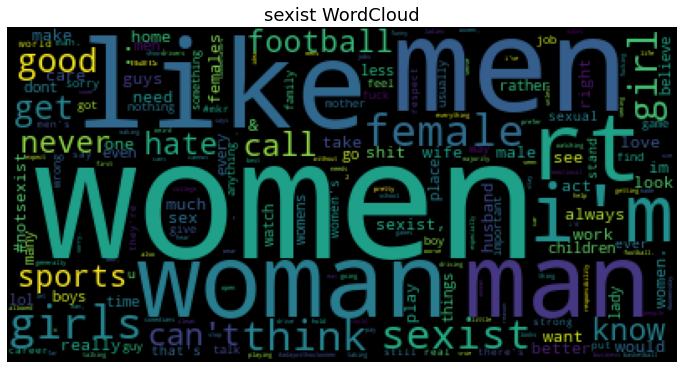

In [20]:
#Let's first plot the sexist WordCloud
types = ['sexist','not_sexist']
word_counter = {}
for categ in types:
    d = Counter()
    data[data[categ] == 1]['clean_tweet'].apply(lambda t: d.update(t.split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index').rename(columns={0: 'count'}).sort_values('count', ascending=False)

w = 'sexist'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

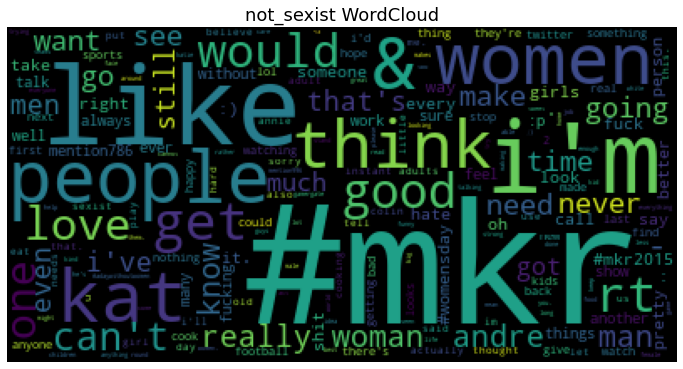

In [21]:
#Let's now plot the not sexist WordCloud
w = 'not_sexist'
wc = word_counter[w]

wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

fig = plt.figure(figsize=(12, 8))
plt.title(w + ' WordCloud', fontsize = 18)
plt.imshow(wordcloud)
plt.axis('off')

**We see that in the sexists tweets some words come more often like the followings : man, men, woman, women, hate, never, football, shit... This is really representative of the sexist content that can be found in those tweets. On the other way, non sexist tweets only show common usage words like : people love, good...**

## III - Tokenization and embeddings
After loading, renriching, cleaning and visualizing the data we can now tokenize it and represent it.

### III.1 - TweetTokeniser
For the tokenization we chose the TweetTokeniser, as used in class

In [22]:
tweet_tokenizer = TweetTokenizer()
data['tweet_token'] = data['clean_tweet'].apply(lambda tweet : tweet_tokenizer.tokenize(tweet) )
data.head(3)

,id,dataset,text,toxicity,sexist,of_id,capitals,uppercase_comments,punctuations,length,words,sentences,emojis,hashtag,clean_tweet,is_sexist,not_sexist,hashtag_content,tweet_token
0,0,other,MENTION3481 i didn't even know random was an o...,0.118180,0,-1,7,0,2,52,9,1,2,0,even know random option!,False,1,[],"[even, know, random, option, !]"
1,1,other,Bottom two should've gone! #mkr,0.251850,0,-1,1,0,3,32,5,1,0,1,bottom two gone! #mkr,False,1,[mkr],"[bottom, two, gone, !, #mkr]"
2,2,callme,MENTION3111 MENTION3424 ladyboner deserves so ...,0.113331,0,-1,14,0,3,103,12,1,7,2,ladyboner deserves much credit dudeboner. #b...,False,1,"[bonerdebate, reddetails]","[ladyboner, deserves, much, credit, dudeboner,..."


### III.2 - TfIdfVEctorizer : Count-based embedding 
These embeddings are designed for the Naive Bayes Classifier. This is a count-based embedding specific to this classification algorithm.


In [23]:
comments = data["clean_tweet"]
comments_vector = TfidfVectorizer(max_features=1000, analyzer='word')
X = comments_vector.fit_transform(comments)
y = data['is_sexist']

### III.3 - Embeddings FastText
FastText provides pretrained embeddings for words, to obtain the embedding of a sentence (or tweet here) we compute the mean of the embeddings of the words in it. These embeddings are based on the word2vec technique.

Computing the FastText embeddings needs to download a large file (>4GB) and load it in ram, which is incompatible with runnig on google colab. This traeatment has been runned locally and the embeddings uploaded on a personnal hosting space.

To obtain those embeddings we use the code under.

In [24]:
"""
#Downloading the FastText pretrained embeddings
wget.download('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz')

#Extract the embeddings
with zipfile.ZipFile("wiki-news-300d-1M.vec.zip","r") as zf:
  zf.extractall()

#Loading the embeddings
ft = fasttext.load_model('cc.en.300.bin')

#Mean of embeddings function, to get the embedding of the whole tweet
def tweet_ft_vector(tokenized_tweet):
  vectors = [ft[token] for token in tokenized_tweet]
  return np.mean(vectors, 0)

#Adding the emebddings to the main database
data['tweet_fasttext'] = data['tweet_token'].progress_apply(tweet_ft_vector)

#In order to run locally : mounting google drive on colab to extract the cleaned database then exporting it
from google.colab import drive
drive.mount('/content/drive')
data.to_pickle('/content/drive/MyDrive/Colab Notebooks/data_processed.pkl')
"""

#Loading the locally computed weights 
wget.download('https://nlpproject.cvlr.fr/data_embeddings_fasttext.pkl')
with open('data_embeddings_fasttext.pkl', "rb") as fh:
  ft_embed = pickle.load(fh)

#Adding them to the main database
data = data.merge(ft_embed, on='id')
data.head(3)

,id,dataset,text,toxicity,sexist,of_id,capitals,uppercase_comments,punctuations,length,words,sentences,emojis,hashtag,clean_tweet,is_sexist,not_sexist,hashtag_content,tweet_token,tweet_fasttext
0,0,other,MENTION3481 i didn't even know random was an o...,0.118180,0,-1,7,0,2,52,9,1,2,0,even know random option!,False,1,[],"[even, know, random, option, !]","[0.0842434, -0.036734268, 0.01627786, 0.019323..."
1,1,other,Bottom two should've gone! #mkr,0.251850,0,-1,1,0,3,32,5,1,0,1,bottom two gone! #mkr,False,1,[mkr],"[bottom, two, gone, !, #mkr]","[0.039748717, 0.013996815, 0.030802777, 0.0571..."
2,2,callme,MENTION3111 MENTION3424 ladyboner deserves so ...,0.113331,0,-1,14,0,3,103,12,1,7,2,ladyboner deserves much credit dudeboner. #b...,False,1,"[bonerdebate, reddetails]","[ladyboner, deserves, much, credit, dudeboner,...","[0.0030562344, 0.03818291, 0.026937142, -0.031..."


## IV - Modelization

### IV.1 - Naive Bayes Classifier
The Naive Bayes Classifier is a probabilist algorithm to classify data (based on frequency of words).

##############################
### NAIVE BAYES CLASSIFIER ###
##############################
Training time : 0.004788637161254883
Accuracy : 0.8892555922258892
Precision : 0.5563218390804597
Recall : 0.6894586894586895
F1-Score : 0.6157760814249363
Confusion matrix :


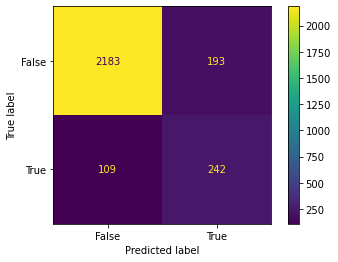

In [25]:
#Splitting the dataset in train and test with random state to have comparability between algortihms
comments_train, comments_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training the model
print('##############################')
print('### NAIVE BAYES CLASSIFIER ###')
print('##############################')
classifier = BernoulliNB()
t0=time.time()
classifier.fit(comments_train, y_train)
t1=time.time()

#Computing the predictions un the test set 
y_pred = classifier.predict(comments_test)

#Evaluating the model
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test, y_pred))
##Precision
print('Precision :', precision_score(y_test, y_pred))
##Recall
print('Recall :', recall_score(y_test, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### IV. 2 - SVM
SVM techniques put the data in a larger dimension space by making operations on the data (power, combinations...) then computes frontiers on this high dimension space.

###########
### SVM ###
###########
Training time : 5.267998933792114
Accuracy : 0.888354898336414
Precision : 0.6782178217821783
Recall : 0.3663101604278075
F1-Score : 0.4756944444444445
Confusion matrix :


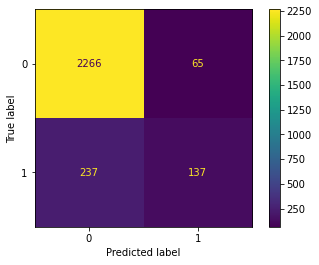

In [26]:
#Excluding data without fastText embeddings (~100 lines)
data_withFT = data[data['tweet_fasttext'].notna()]

#Splitting the dataset in train and test with random state to have comparability between algortihms
X_train, X_test, y_train, y_test = train_test_split(np.stack(data_withFT['tweet_fasttext'].values), data_withFT['sexist'], test_size=0.2, random_state=42)

#Training the model
print('###########')
print('### SVM ###')
print('###########')
svm = SVC()
t0=time.time()
svm.fit(X_train, y_train)
t1=time.time()

#Computing the predictions un the test set 
y_pred = svm.predict(X_test)

#Evaluating the model
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test, y_pred))
##Precision
print('Precision :', precision_score(y_test, y_pred))
##Recall
print('Recall :', recall_score(y_test, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### IV.3 - KNN : K-Nearest Neighbors
KNN algorithms consists in computing the distance with the other points in the dataset and selecting the closest ones (lowest distances). Then use those points to infer the category of the predicted data.

###########
### KNN ###
###########
Training time : 0.003926753997802734
Accuracy : 0.8643253234750462
Precision : 0.5164319248826291
Recall : 0.29411764705882354
F1-Score : 0.37478705281090297
Confusion matrix :


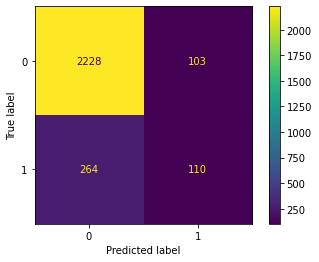

In [27]:
#Excluding data without fastText embeddings (~100 lines)
data_withFT = data[data['tweet_fasttext'].notna()]

#Splitting the dataset in train and test with random state to have comparability between algortihms
X_train, X_test, y_train, y_test = train_test_split(np.stack(data_withFT['tweet_fasttext'].values), data_withFT['sexist'], test_size=0.2, random_state=42)

#Training the model
print('###########')
print('### KNN ###')
print('###########')
KNN = KNeighborsClassifier()
t0=time.time()
KNN.fit(X_train, y_train)
t1=time.time()

#Computing the predictions un the test set 
y_pred = KNN.predict(X_test)

#Evaluating the model
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test, y_pred))
##Precision
print('Precision :', precision_score(y_test, y_pred))
##Recall
print('Recall :', recall_score(y_test, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### IV.4 - Random Forest
A random forest is a collection of a large number of decision trees (ensemble methods). The "voice of the crowd" says if the tweet is sexist of not (if there's more trees that gives a sexist prediction then it's classified sexist and vice versa).

#####################
### Random Forest ###
#####################
Training time : 14.147486686706543
Accuracy : 0.8783733826247689
Precision : 0.6691729323308271
Recall : 0.23796791443850268
F1-Score : 0.3510848126232742
Confusion matrix :


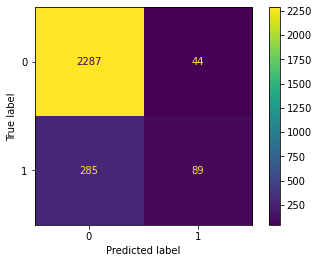

In [28]:
#Excluding data without fastText embeddings (~100 lines)
data_withFT = data[data['tweet_fasttext'].notna()]

#Splitting the dataset in train and test with random state to have comparability between algortihms
X_train, X_test, y_train, y_test = train_test_split(np.stack(data_withFT['tweet_fasttext'].values), data_withFT['sexist'], test_size=0.2, random_state=42)

#Training the model
print('#####################')
print('### Random Forest ###')
print('#####################')
RFC = RandomForestClassifier()
t0=time.time()
RFC.fit(X_train, y_train)
t1=time.time()

#Computing the predictions un the test set 
y_pred = RFC.predict(X_test)

#Evaluating the model
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test, y_pred))
##Precision
print('Precision :', precision_score(y_test, y_pred))
##Recall
print('Recall :', recall_score(y_test, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### IV. 5 - FastText Supervised Classifier
FastText Supervised Classifier is a one hidden layer neural network. It needs a special formatting, ie. each row (tweet) must be in the following format in a text file : `__label__CATEG CONTENT` with `CATEG` being sexist or not sexist and CONTENT the text content of the tweet.

In [29]:
#Selecting the interest columns for the model
data_ft = data_withFT[['sexist', 'clean_tweet']].copy()

#Putting everything in upper case (model requirement)
data_ft['clean_tweet'] = data_ft['clean_tweet'].apply(lambda x : x.upper())

#Converting the sexist variable in the '__label__' format
data_ft['sexist'] = data_ft['sexist'].apply(lambda x : '__label__sexist' if x==1 else '__label__NOTsexist')

#Concatenating the two processed columns before exporting
data_ft['to_export'] = data_ft['sexist'] + ' ' + data_ft['clean_tweet']
data_ft.head(3)

,sexist,clean_tweet,to_export
0,__label__NOTsexist,EVEN KNOW RANDOM OPTION!,__label__NOTsexist EVEN KNOW RANDOM OPTION!
1,__label__NOTsexist,BOTTOM TWO GONE! #MKR,__label__NOTsexist BOTTOM TWO GONE! #MKR
2,__label__NOTsexist,LADYBONER DESERVES MUCH CREDIT DUDEBONER. #B...,__label__NOTsexist LADYBONER DESERVES MUCH C...


######################################
### FastText Supervised Classifier ###
######################################
Training time : 0.21956467628479004
Accuracy : 0.8950092421441774
Precision : 0.640625
Recall : 0.5481283422459893
F1-Score : 0.590778097982709
Confusion matrix :


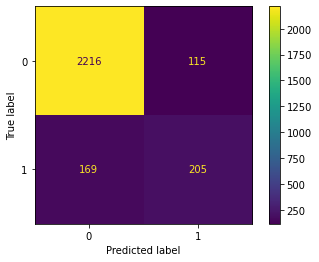

In [30]:
#Splitting the dataset in train and test with random state to have comparability between algortihms
X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(data_ft['to_export'], data_ft['sexist'], test_size=0.2, random_state=42)

#Exporting the train set
lines = list(X_train_ft)
f=open('fastText_encoding.txt', 'a') 
f.writelines("%s\n" % i for i in lines) 
f.close() 

#Exporting the test set
lines = list(X_test_ft)
f=open('fastText_encoding_test.txt', 'a') 
f.writelines("%s\n" % i for i in lines) 
f.close() 

#Training the model
t0=time.time()
model = fasttext.train_supervised('fastText_encoding.txt')
t1=time.time()

#Computing the predictions un the test set 
ft_model_test = pd.DataFrame(X_test_ft).rename(columns={'to_export':'raw_data'})
ft_model_test['sexist'] = ft_model_test['raw_data'].apply(lambda x : x.split(' ')[0])
ft_model_test['content'] = ft_model_test['raw_data'].apply(lambda x : " ".join(x.split(' ')[1:]))
ft_model_test['prediction'] = ft_model_test['content'].apply(lambda x : model.predict(x.replace('\n', ''))[0][0])
ft_model_test['sexist'] = ft_model_test['sexist'].apply(lambda x : 1 if x=='__label__sexist' else 0)
ft_model_test['prediction'] = ft_model_test['prediction'].apply(lambda x : 1 if x=='__label__sexist' else 0)
y_test = ft_model_test['sexist'].values
y_pred = ft_model_test['prediction'].values

#Evaluating the model
print('######################################')
print('### FastText Supervised Classifier ###')
print('######################################')
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test, y_pred))
##Precision
print('Precision :', precision_score(y_test, y_pred))
##Recall
print('Recall :', recall_score(y_test, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### IV.6 - LSTM
LSTM is a simple deep learning model that works well for classification.

######################################
### FastText Supervised Classifier ###
######################################
Composition of the model : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           1866880   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,006,850
Trainable params: 2,006,850
Non-trainable params: 0
_________________________________________________________________

Training :
Epoch 1/4
64/64 [====

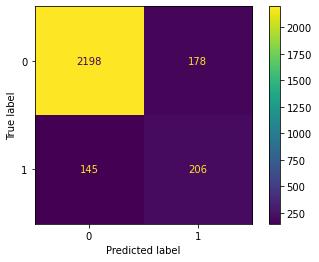

In [31]:
#Encoding the data for the LSTM model
tokenizer = Tokenizer(lower=False)
encoder = LabelEncoder()
tokenizer.fit_on_texts(comments)

#Defining the maximum length of a sequence
MAX_SEQ_LEN = int(comments.apply(lambda x : len(x.split(' '))).quantile(0.95))

#Encoding the data
X_lstm = pad_sequences(tokenizer.texts_to_sequences(comments), maxlen=MAX_SEQ_LEN)
y_lstm = to_categorical(encoder.fit_transform(y))

#Separating the train, validation and test sets
comments_train, comments_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)
comments_train, comments_val, y_train, y_val = train_test_split(comments_train, y_train, test_size=0.25, random_state=42)

#Building the deep learning model (layers)
model = Sequential()
model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN ))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Printing the composition of the model
print('######################################')
print('### FastText Supervised Classifier ###')
print('######################################')
print('Composition of the model : ')
model.summary()
print()

#Training the model
t0 = time.time()
print('Training :')
history = model.fit(comments_train, y_train, batch_size=128, epochs=4, validation_data=(comments_val, y_val))
t1 = time.time()
print()

#Computing the predictions un the test set and reformating the prediction data to evaluate the model
y_pred_scores = model.predict(comments_test)
y_pred = []
for i in range(y_pred_scores.shape[0]):
  y_pred.append(np.where(y_pred_scores[i] == np.amax(y_pred_scores[i]))[0][0])
y_test_unique = []
for i in range(y_test.shape[0]):
  y_test_unique.append(np.where(y_test[i] == np.amax(y_test[i]))[0][0])

#Evaluating the model
print('Evaluation of the model :')
##Training time
print('Training time :', t1-t0)
##Accuracy
print('Accuracy :', accuracy_score(y_test_unique, y_pred))
##Precision
print('Precision :', precision_score(y_test_unique, y_pred))
##Recall
print('Recall :', recall_score(y_test_unique, y_pred))
##F1-Score
print('F1-Score :', f1_score(y_test_unique, y_pred))
##Confusion matrix
print('Confusion matrix :')
_ = ConfusionMatrixDisplay.from_predictions(y_test_unique, y_pred)

## V - Comparison and conclusion
Now that we have all the comparative data we can study our models comparatively to each other.

### V.1 - Comparison table

*Algorithm*                 |Naive Bayes|SVM|KNN|Random Forest|FastText|LSTM|
:--------------------------:|:---------:|:-:|:--------:|:-----------:|:------:|:--:|
**Accuracy**                |0.889|0.888|0.864|0.874|0.895|0.873|
**Precision**               |0.556|0.678|0.516|0.631|0.641|0.505|
**Recall**                  |0.689|0.366|0.294|0.219|0.548|0.664|
**F1-Score**                |0.616|0.476|0.375|0.325|0.591|0.574|
**Training time**           |0.006s|6.541s|0.004s|18.79s|0.272s|12.43s|
**Computational complexity**|$n v$|$n s^2$|$sn\log(n)$|$n_t n\log{(n)} sd$||

With :
- $n$ the number of rows
- $v$ is the number of words in the vocabulary
- $s$ the size of fasttext's embeddings
- $n_{t}$ the number of trees in the random forest
- $d$ the depth of the trees in random forest



### V.2 - Conclusion
We see here two types of models that can work well for our case (mostly based on the F1 score) :
- The probabilist models with Naive Bayes Classifier 
- The deep learning models with FastText's Classifier and LSTM.